# Automated Neural Architecture Search with BootstrapNAS
This notebook demonstrates how to use [BootstrapNAS](https://arxiv.org/abs/2112.10878), a capability in NNCF to generate weight-sharing super-networks from pre-trained models. Once the super-network has been generated, BootstrapNAS can train it and search for efficient sub-networks. 

We will use [MobileNet-V2](https://arxiv.org/abs/1801.04381) pre-trained with CIFAR-10. MobileNet-V2 is an efficient mobile architecture based on inverted residual blocks. Our goal is to discover alternative models, a.k.a., subnetworks, that are more efficient than the input pre-trained model.

\*BootstrapNAS is an **experimental feature** in NNCF.

<p align="center">
<img src="https://github.com/jpablomch/bootstrapnas/raw/main/architecture.png" alt="BootstrapNAS Architecture" width="600"/>
</p>


BootstrapNAS (1) takes as input a pre-trained model. (2) It uses this model to generate a weight-sharing super-network. (3) BootstrapNAS then applies a training strategy, and once the super-network has been trained, (4) it searches for efficient subnetworks that satisfy the user's requirements. (5) The configuration of the discovered sub-network(s) is returned to the user.

## Imports and Settings

Import NNCF and all auxiliary packages to your Python code.
Set a name for the model, and the image width and height that will be used for the network. Also define paths where the output files will be stored. 

> NOTE: All NNCF logging messages below ERROR level (INFO and WARNING) are disabled to simplify the tutorial. For production use, it is recommended to enable logging, by removing ```set_log_level(logging.ERROR)```.

In [1]:
import sys
import time
import zipfile
from pathlib import Path
import logging

import warnings  # to disable warnings on export to ONNX
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

import torch
import nncf  # Important - should be imported directly after torch

import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

from bootstrapnas_utils import MobileNetV2, validate, train_epoch

from nncf.common.utils.logger import set_log_level
set_log_level(logging.ERROR)  # Disables all NNCF info and warning messages

from nncf import NNCFConfig
from nncf.config.structures import BNAdaptationInitArgs
from nncf.experimental.torch.nas.bootstrapNAS import EpochBasedTrainingAlgorithm
from nncf.experimental.torch.nas.bootstrapNAS import SearchAlgorithm
from nncf.torch import create_compressed_model, register_default_init_args
from nncf.torch.initialization import wrap_dataloader_for_init
from nncf.torch.model_creation import create_nncf_network

from openvino.runtime import Core
from torch.jit import TracerWarning

sys.path.append("../utils")
from notebook_utils import download_file

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

MODEL_DIR = Path("model")
OUTPUT_DIR = Path("output")
DATA_DIR = Path("data")
BASE_MODEL_NAME = "mobilenet-V2"
image_size = 32

OUTPUT_DIR.mkdir(exist_ok=True)
MODEL_DIR.mkdir(exist_ok=True)
DATA_DIR.mkdir(exist_ok=True)

# Paths where models will be stored
fp32_pth_path = Path(MODEL_DIR / (BASE_MODEL_NAME + "_fp32")).with_suffix(".pth")
model_onnx_path = Path(OUTPUT_DIR / (BASE_MODEL_NAME )).with_suffix(".onnx")
supernet_onnx_path = Path(OUTPUT_DIR / (BASE_MODEL_NAME + "_supernet")).with_suffix(".onnx")
subnet_onnx_path = Path(OUTPUT_DIR / (BASE_MODEL_NAME + "_subnet")).with_suffix(".onnx")

Using cuda device


## Download pre-trained model weights
Download the pre-trained weights for MobileNet-V2 model.

In [2]:
# It's possible to train FP32 model from scratch, but it might be slow. So the pre-trained weights are downloaded by default.
pretrained_on_cifar10 = True
fp32_pth_url = "http://hsw1.jf.intel.com/share/bootstrapNAS/checkpoints/cifar10/mobilenet_v2.pt"
download_file(fp32_pth_url, directory=MODEL_DIR, filename=fp32_pth_path.name)

'model/mobilenet-V2_fp32.pth' already exists.


PosixPath('/home/jpmunoz/AutoML/openvino_notebooks/notebooks/303-pytorch-bootstrapnas/model/mobilenet-V2_fp32.pth')

## Prepare CIFAR-10 dataset
Next, prepare the CIFAR-10 dataset. The CIFAR-10 dataset contains:
* 60,000 images of shape 3x32x32
* 10 different classes (6,000 images per class): airplane, automobile, etc. 

Here, the dataloader is created for both the training and validation dataset which includes normalization, crop, and other transformation.  Each dataloader uses 4 workers and a batch size of 64 for training and 1000 for validation.

In [3]:
DATASET_DIR = DATA_DIR / "cifar10"

image_size = 32
size = int(image_size / 0.875)
normalize = transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                         std=(0.2471, 0.2435, 0.2616))
list_val_transforms = [
            transforms.ToTensor(),
            normalize
        ]
val_transform = transforms.Compose(list_val_transforms)

list_train_transforms = [
            transforms.RandomCrop(image_size, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize
        ]
    
train_transform = transforms.Compose(list_train_transforms)
    
download = False 
if not DATASET_DIR.exists(): 
    download = True

train_dataset = datasets.CIFAR10(DATASET_DIR, train=True, transform=train_transform, download=download)
val_dataset = datasets.CIFAR10(DATASET_DIR, train=False, transform=val_transform, download=download)

batch_size_val = 1000
batch_size = 64
workers = 4
pin_memory = device != 'cpu'
val_sampler = torch.utils.data.SequentialSampler(val_dataset) 
train_sampler = None
train_shuffle = None

val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size_val, shuffle=False,
        num_workers=workers, pin_memory=pin_memory,
        sampler=val_sampler, drop_last=False)

train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=train_shuffle,
            num_workers=workers, pin_memory=pin_memory, sampler=train_sampler, drop_last=True)


## Generate a super-network from a pre-trained model
 
Using NNCF for model compression assumes that the user has a pre-trained model and a training pipeline. Next, we demonstrate one possible training pipeline.

### Evaluate pre-trained model
Load the pretrained model and evaluate using validation dataset.

In [4]:
model = MobileNetV2()
state_dict = torch.load(fp32_pth_path)
model.load_state_dict(state_dict)

model.to(device)

criterion = nn.CrossEntropyLoss()

model_top1_acc, _, _ = validate(model, val_loader, criterion) 


Test: [ 0/10]	Time 0.616 (0.616)	Loss 0.229 (0.229)	Acc@1 94.10 (94.10)	Acc@5 99.80 (99.80)
 * Acc@1 93.910 Acc@5 99.830


The input pre-trained model has a Top 1 accuracy of **93.91%**. We will use BootstrapNAS to find a sub-network with similar accuracy but more efficient. 

### Train supernetwork
We use the pre-trained MobileNet-V2 model to generate a weight-sharing super-network.

In [5]:
# Configurations
train_steps = 10

config = {
            "device": device,
            "input_info": {
                "sample_size": [1, 3, 32, 32],
            },
            "checkpoint_save_dir": OUTPUT_DIR,
            "bootstrapNAS": {
                "training": {
                    "batchnorm_adaptation": {
                        "num_bn_adaptation_samples": 2
                    },
                    "schedule": {
                        "list_stage_descriptions": [
                            {"train_dims": ["depth"], "epochs": 5, "init_lr": 2.5e-6},
                        ]
                    },
                    "elasticity": {
                        "available_elasticity_dims": ["width", "depth"]
                    },
                    "depth": {
                        "mode": "manual",
                        "skipped_blocks": [
                            [
                                "MobileNetV2/Sequential[features]/InvertedResidual[11]/Sequential[conv]/NNCFConv2d[2]/conv2d_0",
                                "MobileNetV2/Sequential[features]/InvertedResidual[12]/__add___0"
                            ],
                            [
                                "MobileNetV2/Sequential[features]/InvertedResidual[14]/Sequential[conv]/NNCFConv2d[2]/conv2d_0",
                                "MobileNetV2/Sequential[features]/InvertedResidual[15]/__add___0"
                            ]
                        ],
                    }
                },
                "search": {
                    "algorithm": "NSGA2",
                    "num_evals": 5, #30,
                    "population": 2, # 5,
                    "ref_acc": model_top1_acc.item(),
                    "acc_delta": 4
                }
            }
        }

# define optimizer
init_lr = 3e-4
compression_lr = init_lr / 10
optimizer = torch.optim.Adam(model.parameters(), lr=compression_lr)

# Setup

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    nncf_config = NNCFConfig.from_dict(config)

    bn_adapt_args = BNAdaptationInitArgs(data_loader=wrap_dataloader_for_init(train_loader), device=device)
    nncf_config.register_extra_structs([bn_adapt_args])

    nncf_network = create_nncf_network(model, nncf_config)


    # Training
    def train_epoch_fn(loader, model, compression_ctrl, epoch, optimizer):
        train_epoch(loader, model, device, criterion, optimizer, epoch, compression_ctrl, train_iters=train_steps)

    training_algorithm = EpochBasedTrainingAlgorithm.from_config(nncf_network, nncf_config)
    nncf_network, elasticity_ctrl = training_algorithm.run(train_epoch_fn, train_loader,
                                                           validate, val_loader, optimizer,
                                                           OUTPUT_DIR, None,
                                                           train_steps)



Epoch:[0][  0/781]	Time 0.441 (0.441)	Loss 0.143 (0.143)	Acc@1 93.75 (93.75)	Acc@5 100.00 (100.00)
Test: [ 0/10]	Time 0.483 (0.483)	Loss 1.258 (1.258)	Acc@1 60.40 (60.40)	Acc@5 91.90 (91.90)
 * Acc@1 61.470 Acc@5 92.530
Test: [ 0/10]	Time 0.528 (0.528)	Loss 0.272 (0.272)	Acc@1 92.20 (92.20)	Acc@5 99.90 (99.90)
 * Acc@1 92.150 Acc@5 99.810
Epoch:[1][  0/781]	Time 0.399 (0.399)	Loss 0.122 (0.122)	Acc@1 96.88 (96.88)	Acc@5 100.00 (100.00)
Test: [ 0/10]	Time 0.486 (0.486)	Loss 0.924 (0.924)	Acc@1 72.30 (72.30)	Acc@5 95.90 (95.90)
 * Acc@1 73.180 Acc@5 96.330
Test: [ 0/10]	Time 0.534 (0.534)	Loss 0.439 (0.439)	Acc@1 87.70 (87.70)	Acc@5 99.10 (99.10)
 * Acc@1 87.440 Acc@5 99.260
Epoch:[2][  0/781]	Time 0.379 (0.379)	Loss 0.425 (0.425)	Acc@1 89.06 (89.06)	Acc@5 100.00 (100.00)
Test: [ 0/10]	Time 0.495 (0.495)	Loss 0.942 (0.942)	Acc@1 70.70 (70.70)	Acc@5 96.00 (96.00)
 * Acc@1 71.300 Acc@5 96.100
Test: [ 0/10]	Time 0.547 (0.547)	Loss 0.381 (0.381)	Acc@1 88.60 (88.60)	Acc@5 99.40 (99.40)
 * Acc

### Search for sub-networks
Use NSGA2 Search algorithm to obtain the best sub-network
Once the super-network has been trained, use NSGA2 (as specified in configuration) to obtain the best sub-network to satisfy the user's requirements. The configuration of the discovered sub-network(s) and ther performance metrics are returned to the user.

In [6]:
search_algo = SearchAlgorithm.from_config(nncf_network, elasticity_ctrl, nncf_config)

def validate_model_fn_top1(model, val_loader):
    top1, _, _ = validate(model, val_loader, criterion)
    return top1.item()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    elasticity_ctrl, best_config, performance_metrics = search_algo.run(validate_model_fn_top1, val_loader,
                                                                        OUTPUT_DIR,
                                                                        tensorboard_writer=None)

print("Best config: {best_config}".format(best_config=best_config))
print("Performance metrics: {performance_metrics}".format(performance_metrics=performance_metrics))


Test: [ 0/10]	Time 0.569 (0.569)	Loss 0.549 (0.549)	Acc@1 84.50 (84.50)	Acc@5 99.00 (99.00)
 * Acc@1 84.170 Acc@5 98.880
Test: [ 0/10]	Time 0.531 (0.531)	Loss 0.268 (0.268)	Acc@1 93.20 (93.20)	Acc@5 99.70 (99.70)
 * Acc@1 92.990 Acc@5 99.760
Test: [ 0/10]	Time 0.485 (0.485)	Loss 0.634 (0.634)	Acc@1 80.30 (80.30)	Acc@5 99.10 (99.10)
 * Acc@1 81.240 Acc@5 99.030
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |       2 |       2 |            - |            -
Test: [ 0/10]	Time 0.496 (0.496)	Loss 0.553 (0.553)	Acc@1 83.40 (83.40)	Acc@5 99.10 (99.10)
 * Acc@1 83.690 Acc@5 99.160
Test: [ 0/10]	Time 0.559 (0.559)	Loss 0.258 (0.258)	Acc@1 92.90 (92.90)	Acc@5 99.90 (99.90)
 * Acc@1 92.970 Acc@5 99.840
    2 |       4 |       2 |  0.00000E+00 |            f
Best config: OrderedDict([(<ElasticityDim.DEPTH: 'depth'>, [9])])
Performance metrics: [82.923008, 92.97000122070312]


## Visualization of the search stage
After the search has concluded, we can visualize the search progression phase as a PNG file.

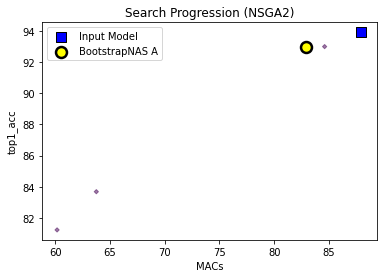

In [7]:
search_algo.visualize_search_progression(filename=Path(OUTPUT_DIR / (BASE_MODEL_NAME + "_search")))

In the example above, we have used just a few epochs to train the super-network. Please refer to the `schedule` section in the configuration file. Increasing the number of training epochs and the elasticity of the super-newtwork will result in a greater search space from which we can extract efficient sub-networks. For instance, this is the result that we get by increasing the number of epochs and the elasticity of the super-network: 


<img src="https://github.com/jpablomch/openvino_notebooks/raw/bootstrapNAS_IntelON/notebooks/303-pytorch-bootstrapnas/mobilenet_v2_bootstrapnas.png" alt="BootstrapNAS MobileNetV2" width="400" align="left" />


As illustrated in the figure, many sub-networks are more efficient than the original pre-trained model without or with little drop in accuracy.
